<a href="https://colab.research.google.com/github/silviolima07/Regression_Apartment_Sales/blob/master/Regressao_Venda_Imovel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Aplicando algoritmos de Regressão
### - Objetivo:
####  Para prever o valor de venda de apartamentos
### - Processo:
####  Dados obtidos através de scrap de 200 páginas da internet
####  Foram coletados 4k anúncios e após removidos os duplicados restaram 3k
####  O score R2 foi aplicado para avaliar se os modelos.
####  Valores obtidos ficaram entre 0.85 e 0.95.
####  Banheiro e quarto são os items menos importantes na previsão.

### Referencia:
- https://www.analyticsvidhya.com/blog/2023/02/how-to-save-and-load-machine-learning-models-in-python-using-joblib-library/#:~:text=Saving%20the%20Model%20Using%20Joblib,-Saving%20our%20trained&text=%23%20save%20the%20model%20to%20a,will%20be%20saved%20as%20'regression_model.

In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


![alt text](https://drive.google.com/uc?id=1Dh8jYdyTpT6IlGYzDXmpiK2hpt6Z0Wdw)

In [45]:
# Isto foi necessário que os modelos gerados tivessem a mesma versão no momento da leitura
# no servidor do Heroku que emitia um aviso de as versões eram diferentes e o pode ocorrer
# comportamentos imprevisiveis do modelo devido a essa diferença
#
!pip install scikit-learn==1.2.2 #0.23.1

In [88]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
from IPython.core.pylabtools import figsize
from IPython.display import display, HTML
import matplotlib.pyplot as plt
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 400)
import seaborn as sns
sns.set(color_codes=True)
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import r2_score
from sklearn import metrics
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from scipy import stats
import pickle
from sklearn import preprocessing
import re
import joblib

In [47]:
# Ajustes

nbairros = 30 # número de bairros a serem considerados no modelo

In [48]:
def count_encode(X, categorical_features, normalize=False):
    print('Count encoding: {}'.format(categorical_features))
    X_ = pd.DataFrame()
    for cat_feature in categorical_features:
        X_[cat_feature] = X[cat_feature].astype(
            'object').map(X[cat_feature].value_counts())
        if normalize:
            X_[cat_feature] = X_[cat_feature] / np.max(X_[cat_feature])
    X_ = X_.add_suffix('_count_encoded')
    if normalize:
        X_ = X_.astype(np.float32)
        X_ = X_.add_suffix('_normalized')
    else:
        X_ = X_.astype(np.uint32)
    return X_

In [49]:
df = pd.read_csv("/content/imovelweb_venda_utf8.csv",encoding = "Latin-1")

In [50]:
df.shape

(4000, 8)

In [51]:
df.columns

Index(['Unnamed: 0', 'price', 'area_total', 'area_util', 'quarto', 'banheiro',
       'vaga', 'bairro'],
      dtype='object')

In [52]:
df = df.drop(columns=['Unnamed: 0'])

In [53]:
df.columns

Index(['price', 'area_total', 'area_util', 'quarto', 'banheiro', 'vaga',
       'bairro'],
      dtype='object')

In [54]:
# Remover linhas duplicadas
#
df = df.drop_duplicates(subset=["price", "area_total","area_util", "quarto", "banheiro", "vaga", "bairro"])
df

,price,area_total,area_util,quarto,banheiro,vaga,bairro
0,R$ 2.450.000,489 m² área total,217 m² área útil,4 Quartos,6 Banheiros,5 Vagas,<span> Campo Belo
1,R$ 2.250.000,115 m² área total,115 m² área útil,1 Quarto,1 Banheiro,1 Vaga,<span> Jardins
2,R$ 770.000,41 m² área total,41 m² área útil,2 Quartos,1 Banheiro,1 Vaga,<span> Vila Nova Conceição
3,R$ 320.000,33 m² área total,33 m² área útil,1 Quarto,1 Banheiro,1 Vaga,<span> Moema
4,R$ 2.070.000,173 m² área total,173 m² área útil,4 Quartos,6 Banheiros,4 Vagas,<span> Perdizes
...,...,...,...,...,...,...,...
3995,R$ 1.678.000,255 m² área total,160 m² área útil,3 Quartos,5 Banheiros,3 Vagas,<span> Aclimação
3996,R$ 260.000,50 m² área total,50 m² área útil,2 Quartos,1 Banheiro,1 Vaga,<span> Vila Marari
3997,R$ 1.430.000,104 m² área total,104 m² área útil,3 Quartos,3 Banheiros,3 Vagas,<span> Chácara Santo Antônio
3998,R$ 315.000,80 m² área total,29 m² área útil,1 Quarto,1 Banheiro,1 Vaga,<span> Bela Vista


## Remover caracteres de price

In [55]:
temp = df.price.str.replace('R\$', '')
df['price_clean'] = temp
#
temp = df.price_clean.str.replace('.', '')
df['price_clean'] = temp
df.price_clean = df.price_clean.astype('int64')
df

,price,area_total,area_util,quarto,banheiro,vaga,bairro,price_clean
0,R$ 2.450.000,489 m² área total,217 m² área útil,4 Quartos,6 Banheiros,5 Vagas,<span> Campo Belo,2450000
1,R$ 2.250.000,115 m² área total,115 m² área útil,1 Quarto,1 Banheiro,1 Vaga,<span> Jardins,2250000
2,R$ 770.000,41 m² área total,41 m² área útil,2 Quartos,1 Banheiro,1 Vaga,<span> Vila Nova Conceição,770000
3,R$ 320.000,33 m² área total,33 m² área útil,1 Quarto,1 Banheiro,1 Vaga,<span> Moema,320000
4,R$ 2.070.000,173 m² área total,173 m² área útil,4 Quartos,6 Banheiros,4 Vagas,<span> Perdizes,2070000
...,...,...,...,...,...,...,...,...
3995,R$ 1.678.000,255 m² área total,160 m² área útil,3 Quartos,5 Banheiros,3 Vagas,<span> Aclimação,1678000
3996,R$ 260.000,50 m² área total,50 m² área útil,2 Quartos,1 Banheiro,1 Vaga,<span> Vila Marari,260000
3997,R$ 1.430.000,104 m² área total,104 m² área útil,3 Quartos,3 Banheiros,3 Vagas,<span> Chácara Santo Antônio,1430000
3998,R$ 315.000,80 m² área total,29 m² área útil,1 Quarto,1 Banheiro,1 Vaga,<span> Bela Vista,315000


## Remover caracteres em area_total

In [56]:
temp = df.area_total.replace(to_replace=r'[a-zá²]*', value='', regex=True)
df['area_total_clean'] = temp
#
df.area_total_clean = df.area_total_clean.astype('int64')
df

,price,area_total,area_util,quarto,banheiro,vaga,bairro,price_clean,area_total_clean
0,R$ 2.450.000,489 m² área total,217 m² área útil,4 Quartos,6 Banheiros,5 Vagas,<span> Campo Belo,2450000,489
1,R$ 2.250.000,115 m² área total,115 m² área útil,1 Quarto,1 Banheiro,1 Vaga,<span> Jardins,2250000,115
2,R$ 770.000,41 m² área total,41 m² área útil,2 Quartos,1 Banheiro,1 Vaga,<span> Vila Nova Conceição,770000,41
3,R$ 320.000,33 m² área total,33 m² área útil,1 Quarto,1 Banheiro,1 Vaga,<span> Moema,320000,33
4,R$ 2.070.000,173 m² área total,173 m² área útil,4 Quartos,6 Banheiros,4 Vagas,<span> Perdizes,2070000,173
...,...,...,...,...,...,...,...,...,...
3995,R$ 1.678.000,255 m² área total,160 m² área útil,3 Quartos,5 Banheiros,3 Vagas,<span> Aclimação,1678000,255
3996,R$ 260.000,50 m² área total,50 m² área útil,2 Quartos,1 Banheiro,1 Vaga,<span> Vila Marari,260000,50
3997,R$ 1.430.000,104 m² área total,104 m² área útil,3 Quartos,3 Banheiros,3 Vagas,<span> Chácara Santo Antônio,1430000,104
3998,R$ 315.000,80 m² área total,29 m² área útil,1 Quarto,1 Banheiro,1 Vaga,<span> Bela Vista,315000,80


## Remover caracteres em area_util

In [57]:
temp = df.area_util.replace(to_replace=r'[a-záú²]*', value='', regex=True)
df['area_util_clean'] = temp
#
df.area_util_clean = df.area_util_clean.astype('int64')
df


,price,area_total,area_util,quarto,banheiro,vaga,bairro,price_clean,area_total_clean,area_util_clean
0,R$ 2.450.000,489 m² área total,217 m² área útil,4 Quartos,6 Banheiros,5 Vagas,<span> Campo Belo,2450000,489,217
1,R$ 2.250.000,115 m² área total,115 m² área útil,1 Quarto,1 Banheiro,1 Vaga,<span> Jardins,2250000,115,115
2,R$ 770.000,41 m² área total,41 m² área útil,2 Quartos,1 Banheiro,1 Vaga,<span> Vila Nova Conceição,770000,41,41
3,R$ 320.000,33 m² área total,33 m² área útil,1 Quarto,1 Banheiro,1 Vaga,<span> Moema,320000,33,33
4,R$ 2.070.000,173 m² área total,173 m² área útil,4 Quartos,6 Banheiros,4 Vagas,<span> Perdizes,2070000,173,173
...,...,...,...,...,...,...,...,...,...,...
3995,R$ 1.678.000,255 m² área total,160 m² área útil,3 Quartos,5 Banheiros,3 Vagas,<span> Aclimação,1678000,255,160
3996,R$ 260.000,50 m² área total,50 m² área útil,2 Quartos,1 Banheiro,1 Vaga,<span> Vila Marari,260000,50,50
3997,R$ 1.430.000,104 m² área total,104 m² área útil,3 Quartos,3 Banheiros,3 Vagas,<span> Chácara Santo Antônio,1430000,104,104
3998,R$ 315.000,80 m² área total,29 m² área útil,1 Quarto,1 Banheiro,1 Vaga,<span> Bela Vista,315000,80,29


## Remover caracteres em quarto / banheiro / vaga

In [58]:
temp = df.quarto.replace(to_replace=r'[A-Za-z]*', value='', regex=True)
df['quarto_clean'] = temp
#
temp = df.banheiro.replace(to_replace=r'[A-Za-z]*', value='', regex=True)
df['banheiro_clean'] = temp
#
temp = df.vaga.replace(to_replace=r'[A-Za-z]*', value='', regex=True)
df['vaga_clean'] = temp
#
df.quarto_clean = df.quarto_clean.astype('int64')
df.banheiro_clean = df.banheiro_clean.astype('int64')
df.vaga_clean = df.vaga_clean.astype('int64')
df


,price,area_total,area_util,quarto,banheiro,vaga,bairro,price_clean,area_total_clean,area_util_clean,quarto_clean,banheiro_clean,vaga_clean
0,R$ 2.450.000,489 m² área total,217 m² área útil,4 Quartos,6 Banheiros,5 Vagas,<span> Campo Belo,2450000,489,217,4,6,5
1,R$ 2.250.000,115 m² área total,115 m² área útil,1 Quarto,1 Banheiro,1 Vaga,<span> Jardins,2250000,115,115,1,1,1
2,R$ 770.000,41 m² área total,41 m² área útil,2 Quartos,1 Banheiro,1 Vaga,<span> Vila Nova Conceição,770000,41,41,2,1,1
3,R$ 320.000,33 m² área total,33 m² área útil,1 Quarto,1 Banheiro,1 Vaga,<span> Moema,320000,33,33,1,1,1
4,R$ 2.070.000,173 m² área total,173 m² área útil,4 Quartos,6 Banheiros,4 Vagas,<span> Perdizes,2070000,173,173,4,6,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,R$ 1.678.000,255 m² área total,160 m² área útil,3 Quartos,5 Banheiros,3 Vagas,<span> Aclimação,1678000,255,160,3,5,3
3996,R$ 260.000,50 m² área total,50 m² área útil,2 Quartos,1 Banheiro,1 Vaga,<span> Vila Marari,260000,50,50,2,1,1
3997,R$ 1.430.000,104 m² área total,104 m² área útil,3 Quartos,3 Banheiros,3 Vagas,<span> Chácara Santo Antônio,1430000,104,104,3,3,3
3998,R$ 315.000,80 m² área total,29 m² área útil,1 Quarto,1 Banheiro,1 Vaga,<span> Bela Vista,315000,80,29,1,1,1


## Remover caracteres em bairro

In [59]:
temp = df.bairro.replace(to_replace=r'<span>', value='', regex=True)
df['bairro_clean'] = temp
#
df


,price,area_total,area_util,quarto,banheiro,vaga,bairro,price_clean,area_total_clean,area_util_clean,quarto_clean,banheiro_clean,vaga_clean,bairro_clean
0,R$ 2.450.000,489 m² área total,217 m² área útil,4 Quartos,6 Banheiros,5 Vagas,<span> Campo Belo,2450000,489,217,4,6,5,Campo Belo
1,R$ 2.250.000,115 m² área total,115 m² área útil,1 Quarto,1 Banheiro,1 Vaga,<span> Jardins,2250000,115,115,1,1,1,Jardins
2,R$ 770.000,41 m² área total,41 m² área útil,2 Quartos,1 Banheiro,1 Vaga,<span> Vila Nova Conceição,770000,41,41,2,1,1,Vila Nova Conceição
3,R$ 320.000,33 m² área total,33 m² área útil,1 Quarto,1 Banheiro,1 Vaga,<span> Moema,320000,33,33,1,1,1,Moema
4,R$ 2.070.000,173 m² área total,173 m² área útil,4 Quartos,6 Banheiros,4 Vagas,<span> Perdizes,2070000,173,173,4,6,4,Perdizes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,R$ 1.678.000,255 m² área total,160 m² área útil,3 Quartos,5 Banheiros,3 Vagas,<span> Aclimação,1678000,255,160,3,5,3,Aclimação
3996,R$ 260.000,50 m² área total,50 m² área útil,2 Quartos,1 Banheiro,1 Vaga,<span> Vila Marari,260000,50,50,2,1,1,Vila Marari
3997,R$ 1.430.000,104 m² área total,104 m² área útil,3 Quartos,3 Banheiros,3 Vagas,<span> Chácara Santo Antônio,1430000,104,104,3,3,3,Chácara Santo Antônio
3998,R$ 315.000,80 m² área total,29 m² área útil,1 Quarto,1 Banheiro,1 Vaga,<span> Bela Vista,315000,80,29,1,1,1,Bela Vista


In [60]:
df.columns

Index(['price', 'area_total', 'area_util', 'quarto', 'banheiro', 'vaga',
       'bairro', 'price_clean', 'area_total_clean', 'area_util_clean',
       'quarto_clean', 'banheiro_clean', 'vaga_clean', 'bairro_clean'],
      dtype='object')

In [61]:
df2 = df.drop([ 'price', 'area_total', 'area_util', 'banheiro', 'vaga','quarto', 'bairro'], axis=1)

In [62]:
df2.rename(columns={'price_clean':'price', 'area_total_clean':'area_total', 'area_util_clean':'area_util', 'quarto_clean':'quarto', 'banheiro_clean':'banheiro', 'vaga_clean':'vaga', 'bairro_clean':'bairro'}, inplace=True)

In [63]:
df2['bairro'] = df2['bairro'].str.lstrip()

In [64]:
df2.describe()

,price,area_total,area_util,quarto,banheiro,vaga
count,3.213000e+03,3213.000000,3213.000000,3213.000000,3213.000000,3213.00000
mean,2.837114e+06,203.926237,99.003735,2.220355,2.276066,1.81357
std,6.137541e+07,1505.895119,96.099030,1.049519,1.529304,1.15155
min,3.820000e+02,12.000000,12.000000,0.000000,1.000000,1.00000
25%,3.800000e+05,59.000000,47.000000,1.000000,1.000000,1.00000
50%,6.500000e+05,85.000000,70.000000,2.000000,2.000000,1.00000
75%,1.200000e+06,144.000000,120.000000,3.000000,3.000000,2.00000
max,2.960000e+09,40000.000000,1980.000000,7.000000,11.000000,14.00000


In [65]:
# Número de bairros que possuem anúncios de apartamentos a venda
df2.bairro.nunique()

299

In [66]:
# Número de anúncios por bairro
# nbairros vale 30, apenas para filtrar os 30 maiores valores
df2.bairro.value_counts()[:nbairros]

Moema                    161
Jardins                  148
Perdizes                 137
Itaim Bibi               124
Vila Olímpia             115
Brooklin                 112
Jardim Paulista           96
Pinheiros                 82
Vila Mariana              77
Vila Nova Conceição       75
Vila Mascote              70
Jardim Marajoara          65
Ipiranga                  64
Vila Romana               61
Bela Vista                59
Vila Leopoldina           59
Morumbi                   59
Campo Belo                58
Santana                   53
Chácara Santo Antônio     50
Saúde                     48
Cerqueira César           48
Pompéia                   41
Tatuapé                   41
Paraíso                   40
Jabaquara                 38
Higien                    36
Barra Funda               35
Consolação                34
Vila Guarani              33
Name: bairro, dtype: int64

In [67]:
# Contar quantas vezes cada bairro aparece no dataset e criar uma coluna com esse valor
temp = count_encode(df2,['bairro']);


Count encoding: ['bairro']


In [68]:
df2['anuncios'] = temp
df2

,price,area_total,area_util,quarto,banheiro,vaga,bairro,anuncios
0,2450000,489,217,4,6,5,Campo Belo,58
1,2250000,115,115,1,1,1,Jardins,148
2,770000,41,41,2,1,1,Vila Nova Conceição,75
3,320000,33,33,1,1,1,Moema,161
4,2070000,173,173,4,6,4,Perdizes,137
...,...,...,...,...,...,...,...,...
3995,1678000,255,160,3,5,3,Aclimação,28
3996,260000,50,50,2,1,1,Vila Marari,3
3997,1430000,104,104,3,3,3,Chácara Santo Antônio,50
3998,315000,80,29,1,1,1,Bela Vista,59


In [69]:
# Filtrar e selecionar os bairros com  50 ou mais anuncios
df3 = df2.loc[df2['anuncios'] >= 50]
df3 = df3.sort_values(by='anuncios', ascending=False)

In [70]:
df3.head()

,price,area_total,area_util,quarto,banheiro,vaga,bairro,anuncios
3196,1500000,110,110,3,4,2,Moema,161
1230,1530000,127,127,3,3,3,Moema,161
1623,2495000,141,141,2,5,3,Moema,161
3465,1000000,200,143,2,4,5,Moema,161
1543,340000,65,33,1,1,1,Moema,161


In [71]:
listaBairro = list(df3.bairro.unique())

In [72]:
listaBairro

['Moema',
 'Jardins',
 'Perdizes',
 'Itaim Bibi',
 'Vila Olímpia',
 'Brooklin',
 'Jardim Paulista',
 'Pinheiros',
 'Vila Mariana',
 'Vila Nova Conceição',
 'Vila Mascote',
 'Jardim Marajoara',
 'Ipiranga',
 'Vila Romana',
 'Morumbi',
 'Bela Vista',
 'Vila Leopoldina',
 'Campo Belo',
 'Santana',
 'Chácara Santo Antônio']

In [73]:
# Função pra criar o dataset com os dados de cada bairro na listaBairro
#
def filtraBairro(df, bairro):
  temp = df.loc[df.bairro == bairro]
  temp = temp.drop(['bairro', 'anuncios'], axis=1)
  return temp


In [74]:
# Checar outliers
def plot_outliers(df,var):
  sns.boxplot(x=df[var]);

In [75]:
# Remover outliers do conjunto de dados do bairro
def remover_outliers(df):
    z = np.abs(stats.zscore(df))
    temp  = df[(z < 2.5).all(axis=1)]
    return temp


In [95]:
def criar_modelo(bairro,df, nome_alg, algoritmo):
  y = np.log1p(df.price) # Caso o target seja um valor monetário é recomendado
                         # aplicar essa transformação nos dados
  X =  df.drop(['price'], axis=1)
  #
  #
  # Break off validation set from training data
  X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7,
                                                      test_size=0.3,random_state=42)
  # Treinar o modelo
  reg = algoritmo
  reg.fit(X_train, y_train)
  #
  # Testar com dados de teste
  pred = reg.predict(X_test)
  #
  # Avaliar R2 score
  r2 = r2_score(y_test, pred)
  print("Bairro:", bairro, "Modelo:", nome_alg, "R2 score:", round(r2,2))
  #
  if bairro == 'Moema':
      r2 = round(r2,2)
      filename = nome_alg+'-Moema-'+str(r2)+'.joblib'
      #pickle.dump(reg, open(filename, 'wb'))
      # joblib
      with open(filename, 'wb') as f:
        joblib.dump(reg, f)
        print("Created")

  if bairro == 'Itaim Bibi':
      r2 = round(r2,2)
      filename = nome_alg+'-Itaim_Bibi-'+str(r2)+'.joblib'
      #pickle.dump(reg, open(filename, 'wb'))

       # joblib
      with open(filename, 'wb') as f:
        joblib.dump(reg, f)
        print("Created")

  if bairro == 'Vila Mariana':
      r2 = round(r2,2)
      filename = nome_alg+'-Vila_Mariana-'+str(r2)+'.joblib'
      #pickle.dump(reg, open(filename, 'wb'))

       # joblib
      with open(filename, 'wb') as f:
        joblib.dump(reg, f)
        print("Created")
  print("Salvando modelo")
  return (reg)



## Três bairros foram selecionados para serem treinados e avaliados
####  - Moema com 161 anúncios
####  - Itaim Bibi com 124
####  - Vila Mariana com 77

## Algoritmos utilizados

In [77]:
# Algoritmos a serem usados
nome_alg = ['RandomForestRegressor', 'DecisionTreeRegressor', 'KNeighborsRegressor', 'ExtraTreesRegressor']
lista_reg = [RandomForestRegressor(n_estimators=250),DecisionTreeRegressor(), KNeighborsRegressor(), ExtraTreesRegressor(n_estimators=150)]

In [78]:
df3.columns

Index(['price', 'area_total', 'area_util', 'quarto', 'banheiro', 'vaga',
       'bairro', 'anuncios'],
      dtype='object')

## Qual a importância das variáveis na previsão do valor de venda?
### Foram considerados apenas os items area (total e útil), número de quartos, banheiros e vagas.
### Pois os modelos foram treinados com os dados de cada bairro.

In [79]:
# Descobrir a importância das variáveis usando o algoritmo RandomForestRegressor
y = np.log1p(df3.price)
X =  df3.drop(['price'], axis=1)
X =  X.drop(['bairro'], axis=1)
X =  X.drop(['anuncios'], axis=1)
X
#
# Break off validation set from training data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, test_size=0.3,random_state=42)
#
# Treinar o modelo
reg = lista_reg[0]
reg.fit(X_train, y_train)
#
feature_importances = pd.DataFrame(reg.feature_importances_,index =
                                   X_train.columns,columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
area_util,0.898617
area_total,0.048039
vaga,0.019207
banheiro,0.017346
quarto,0.016791


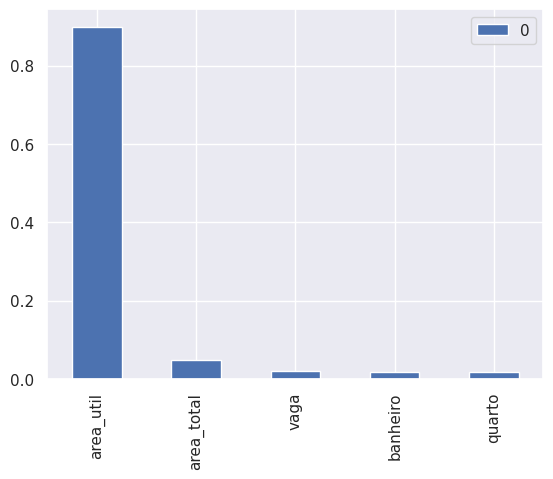

In [80]:
importances = list(zip(reg.feature_importances_, X_train.columns))
importances.sort(reverse=True)
pd.DataFrame(importances, index=[x for (_,x) in importances]).plot(kind = 'bar');

## Treinar e avaliar modelo

In [96]:
# Selecionar os bairros cujos modelos seráo criados.
# Foram escolhidos os bairros: Moema, Itaim Bibi e Vila Mariana
# Recomendo fazer um bairro de cada vez
#
lista_bairros = ['Moema', 'Itaim Bibi', 'Vila Mariana']
#lista_bairros = ['Moema'] # Treinamento e avaliação sera feita com este bairro
size = len(lista_reg)
modelos_treinados = []
for b in range(len(lista_bairros)):
  bairro = lista_bairros[b]
  print("Treinando, avaliando e salvando modelos\n")
  df4 = filtraBairro(df3, bairro)
  df5 = remover_outliers(df4)
  for i in range(size):
      reg = criar_modelo(bairro,df5, nome_alg[i],lista_reg[i])
      modelos_treinados.append(reg)
      print("done")
  print("\nCriando os regressores para download, de refresh em Arquivos caso não apareça")
  print("Remova antes caso rode novamente\n")



Treinando, avaliando e salvando modelos

Bairro: Moema Modelo: RandomForestRegressor R2 score: 0.93
Created
Salvando modelo
done
Bairro: Moema Modelo: DecisionTreeRegressor R2 score: 0.93
Created
Salvando modelo
done
Bairro: Moema Modelo: KNeighborsRegressor R2 score: 0.77
Created
Salvando modelo
done
Bairro: Moema Modelo: ExtraTreesRegressor R2 score: 0.93
Created
Salvando modelo
done

Criando os regressores para download, de refresh em Arquivos caso não apareça
Remova antes caso rode novamente

Treinando, avaliando e salvando modelos

Bairro: Itaim Bibi Modelo: RandomForestRegressor R2 score: 0.9
Created
Salvando modelo
done
Bairro: Itaim Bibi Modelo: DecisionTreeRegressor R2 score: 0.84
Created
Salvando modelo
done
Bairro: Itaim Bibi Modelo: KNeighborsRegressor R2 score: 0.89
Created
Salvando modelo
done
Bairro: Itaim Bibi Modelo: ExtraTreesRegressor R2 score: 0.83
Created
Salvando modelo
done

Criando os regressores para download, de refresh em Arquivos caso não apareça
Remova ante

## Teste do modelo com dados conhecidos
## Ou com dados obtidos de anúncios na internet

In [82]:
# Escolha um dos modelos treinados
modelos_treinados

[RandomForestRegressor(n_estimators=250),
 DecisionTreeRegressor(),
 KNeighborsRegressor(),
 ExtraTreesRegressor(n_estimators=150),
 RandomForestRegressor(n_estimators=250),
 DecisionTreeRegressor(),
 KNeighborsRegressor(),
 ExtraTreesRegressor(n_estimators=150),
 RandomForestRegressor(n_estimators=250),
 DecisionTreeRegressor(),
 KNeighborsRegressor(),
 ExtraTreesRegressor(n_estimators=150)]

In [83]:
#
reg = modelos_treinados[0]
dados = np.array([90,55,1,1,1]) # O modelo foi treinado com 5 variaveis (colunas)
dados = dados.reshape(1,5)        # Esse reshape cria uma matriz com 1 linha e 5 colunas
pred_teste = reg.predict(dados)   # Dessa forma o modelo consegue usar as informações.
#
# np.array([65,33,1,1,1]) = 340000        0 Moema
# np.array([110,110,3,4,2]) = 1500000     0
# np.array([65,38,1,1,1]) = 410000        3 Itaim Bibi
# np.array([57, 57,2,2,2]) = 650000       8 Vila Mariana
# np.array([23, 23,1,1,1]) = 250000       8


resultado = np.round(np.expm1(pred_teste),0) # No treinamento a variavel price foi transformada
print (resultado)                            # Aplicando-se o np.log, portanto na validação com testes reais
                                             # É necessário retornar ao valor real com np.expm1

[531108.]


In [87]:
pip freeze > teste.txt